In [1]:
# ==========================================
# Projeto: Limpeza e Validação de Dados - E-commerce
# Autor: Gustavo Bueno
# Descrição:
#   Script responsável por leitura, limpeza,
#   validação e integração de dados utilizando PySpark.
# ==========================================

# --- Imports padrão ---
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col,
    sum as spark_sum,
    count,
    when,
    regexp_replace,
    countDistinct
)
from pyspark.sql.types import (
    IntegerType,
    DoubleType,
    StringType,
    DateType
)

# --- Inicialização da SparkSession ---
spark = SparkSession.builder \
    .appName("EcommerceDataCleaning") \
    .config("spark.sql.legacy.timeParserPolicy", "LEGACY") \
    .getOrCreate()

# Nova seção

# Nova seção

In [2]:
from pyspark.sql.functions.builtin import product
sales_data = spark.read.csv('/content/sales_data.csv', inferSchema=True, header=True)
customer_info = spark.read.csv('/content/customer_info.csv', inferSchema=True, header=True)
product_info = spark.read.csv('/content/product_info.csv', inferSchema=True, header=True)



In [3]:
from pyspark.sql.functions import col, unix_timestamp, from_unixtime, expr
from pyspark.sql.types import (
    IntegerType,
    DoubleType,
    StringType,
    DateType
)

# Estrutura dos dados
sales_data = sales_data.withColumn('quantity', expr("try_cast(quantity AS INT)")) \
    .withColumn('unit_price', col('unit_price').cast(DoubleType()))
sales_data = sales_data.withColumn('order_date', from_unixtime(unix_timestamp(col('order_date'), 'dd-MM-yy'), 'yyyy-MM-dd').cast(DateType())).cache()

customer_info = customer_info.withColumn('signup_date', from_unixtime(unix_timestamp(col('signup_date'), 'dd-MM-yy'), 'yyyy-MM-dd').cast(DateType())).cache()

product_info = product_info.withColumn('launch_date', from_unixtime(unix_timestamp(col('launch_date'), 'dd-MM-yy'), 'yyyy-MM-dd').cast(DateType())).cache()

sales_data.printSchema()
customer_info.printSchema()
product_info.printSchema()

root
 |-- order_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- quantity: integer (nullable = true)
 |-- unit_price: double (nullable = true)
 |-- order_date: date (nullable = true)
 |-- delivery_status: string (nullable = true)
 |-- payment_method: string (nullable = true)
 |-- region: string (nullable = true)
 |-- discount_applied: double (nullable = true)

root
 |-- customer_id: string (nullable = true)
 |-- email: string (nullable = true)
 |-- signup_date: date (nullable = true)
 |-- gender: string (nullable = true)
 |-- region: string (nullable = true)
 |-- loyalty_tier: string (nullable = true)

root
 |-- product_id: string (nullable = true)
 |-- product_name: string (nullable = true)
 |-- category: string (nullable = true)
 |-- launch_date: date (nullable = true)
 |-- base_price: double (nullable = true)
 |-- supplier_code: string (nullable = true)



In [4]:
# limpeza de dados

#quantidade nulos antes
sales_data.select([spark_sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in sales_data.columns]).show()
customer_info.select([spark_sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in customer_info.columns]).show()
product_info.select([spark_sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in product_info.columns]).show()

+--------+-----------+----------+--------+----------+----------+---------------+--------------+------+----------------+
|order_id|customer_id|product_id|quantity|unit_price|order_date|delivery_status|payment_method|region|discount_applied|
+--------+-----------+----------+--------+----------+----------+---------------+--------------+------+----------------+
|       1|          2|         5|       5|         1|         3|              3|             3|     0|             517|
+--------+-----------+----------+--------+----------+----------+---------------+--------------+------+----------------+

+-----------+-----+-----------+------+------+------------+
|customer_id|email|signup_date|gender|region|loyalty_tier|
+-----------+-----+-----------+------+------+------------+
|          3|    6|          4|     4|     3|           2|
+-----------+-----+-----------+------+------+------------+

+----------+------------+--------+-----------+----------+-------------+
|product_id|product_name|catego

In [5]:
# duplicadas
sales_data.count() - sales_data.dropDuplicates().count()
customer_info.count() - customer_info.dropDuplicates().count()
product_info.count() - product_info.dropDuplicates().count()

#duplicidade por id
sales_data.groupBy("order_id").count().filter(col("count")>1).show()
customer_info.groupBy("customer_id").count().filter(col("count")>1).show()
product_info.groupBy("product_id").count().filter(col("count")>1).show()

+--------+-----+
|order_id|count|
+--------+-----+
| O515400|    2|
| O916245|    2|
+--------+-----+

+-----------+-----+
|customer_id|count|
+-----------+-----+
|       NULL|    3|
+-----------+-----+

+----------+-----+
|product_id|count|
+----------+-----+
+----------+-----+



In [6]:
sales_data.count()

df_join1 = sales_data.join(
    customer_info,
    sales_data.customer_id == customer_info.customer_id,
    "left"
).drop(customer_info.customer_id).drop(customer_info.region)

df_join1.count()

df_final = df_join1.join(
    product_info ,
    "product_id",
    "left"
)

contar_nulos = df_final.select([spark_sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in df_final.columns]).show()

df_final.show()

+----------+--------+-----------+--------+----------+----------+---------------+--------------+------+----------------+-----+-----------+------+------------+------------+--------+-----------+----------+-------------+
|product_id|order_id|customer_id|quantity|unit_price|order_date|delivery_status|payment_method|region|discount_applied|email|signup_date|gender|loyalty_tier|product_name|category|launch_date|base_price|supplier_code|
+----------+--------+-----------+--------+----------+----------+---------------+--------------+------+----------------+-----+-----------+------+------------+------------+--------+-----------+----------+-------------+
|         5|       1|          2|       5|         1|         3|              3|             3|     0|             517|   57|         54|    44|          35|           5|       5|          5|         5|            5|
+----------+--------+-----------+--------+----------+----------+---------------+--------------+------+----------------+-----+-------

In [7]:
# Substituindo e removendo nulos
df_final = df_final.dropna(subset=['product_id', 'order_id', 'customer_id', 'product_id', 'order_date','quantity', 'unit_price'])
contar_nulos = df_final.select([spark_sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in df_final.columns]).show()

df_final = df_final.fillna({
    'delivery_status': 'Unknown',
    'payment_method': 'Unknown',
    'region': 'Unknown',
    'discount_applied': 0.0,
    'loyalty_tier': 'None',
    'category': 'Unknown' # Corrigido de 'product_category' para 'category'
})
contar_nulos = df_final.select([spark_sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in df_final.columns]).show()

# Vou manter colunas descritivas como nulas


+----------+--------+-----------+--------+----------+----------+---------------+--------------+------+----------------+-----+-----------+------+------------+------------+--------+-----------+----------+-------------+
|product_id|order_id|customer_id|quantity|unit_price|order_date|delivery_status|payment_method|region|discount_applied|email|signup_date|gender|loyalty_tier|product_name|category|launch_date|base_price|supplier_code|
+----------+--------+-----------+--------+----------+----------+---------------+--------------+------+----------------+-----+-----------+------+------------+------------+--------+-----------+----------+-------------+
|         0|       0|          0|       0|         0|         0|              3|             3|     0|             513|   55|         52|    42|          33|           0|       0|          0|         0|            0|
+----------+--------+-----------+--------+----------+----------+---------------+--------------+------+----------------+-----+-------

In [8]:
df_final.show()

+----------+--------+-----------+--------+----------+----------+---------------+--------------+-------+----------------+--------------------+-----------+------+------------+--------------------+-------------+-----------+----------+-------------+
|product_id|order_id|customer_id|quantity|unit_price|order_date|delivery_status|payment_method| region|discount_applied|               email|signup_date|gender|loyalty_tier|        product_name|     category|launch_date|base_price|supplier_code|
+----------+--------+-----------+--------+----------+----------+---------------+--------------+-------+----------------+--------------------+-----------+------+------------+--------------------+-------------+-----------+----------+-------------+
|     P0022| O966977|     C00397|       3|     39.25|2025-07-06|      Delivered|        PayPal|Central|             0.0|jacquelinemartin@...| 2024-09-08|Female|      Silver| Cleaning Product 86|     Cleaning| 2024-10-04|     19.77|         S924|
|     P0023| O69

In [9]:
from pyspark.sql.functions import col, expr
# Criação de métricas

df_com_receita_total = df_final.withColumn(
    'calculated_quantity', expr("try_cast(quantity AS DOUBLE)")
).withColumn(
    'receita_total',
    col('calculated_quantity') * col('unit_price')
).fillna(0.0, subset=['receita_total']) # Fill NULLs in receita_total resulting from malformed quantities

df_com_receita_total.show()

+----------+--------+-----------+--------+----------+----------+---------------+--------------+-------+----------------+--------------------+-----------+------+------------+--------------------+-------------+-----------+----------+-------------+-------------------+------------------+
|product_id|order_id|customer_id|quantity|unit_price|order_date|delivery_status|payment_method| region|discount_applied|               email|signup_date|gender|loyalty_tier|        product_name|     category|launch_date|base_price|supplier_code|calculated_quantity|     receita_total|
+----------+--------+-----------+--------+----------+----------+---------------+--------------+-------+----------------+--------------------+-----------+------+------------+--------------------+-------------+-----------+----------+-------------+-------------------+------------------+
|     P0022| O966977|     C00397|       3|     39.25|2025-07-06|      Delivered|        PayPal|Central|             0.0|jacquelinemartin@...| 202

In [10]:
receita_por_cliente = df_com_receita_total.groupBy('customer_id').agg(spark_sum('receita_total').alias('receita_total_por_cliente'))
receita_por_cliente.show()

+-----------+-------------------------+
|customer_id|receita_total_por_cliente|
+-----------+-------------------------+
|     C00126|        740.6899999999999|
|     C00394|       405.59999999999997|
|     C00169|                   408.67|
|     C00049|                    376.8|
|     C00006|        535.4599999999999|
|     C00310|        987.8600000000001|
|     C00057|                   287.36|
|     C00195|                   386.51|
|     C00261|                   187.79|
|     C00172|        537.4300000000001|
|     C00244|                   585.28|
|     C00061|                   486.26|
|     C00075|                   189.82|
|     C00306|                   269.56|
|     C00196|       507.36999999999995|
|     C00239|                    307.9|
|     C00311|                   714.29|
|     C00156|                   270.43|
|     C00174|       1151.3300000000002|
|     C00439|                   211.89|
+-----------+-------------------------+
only showing top 20 rows


In [11]:
from pyspark.sql.functions import col, expr, sum as spark_sum, when

df_join1 = sales_data.join(
    customer_info,
    sales_data.customer_id == customer_info.customer_id,
    "left"
).drop(customer_info.customer_id).drop(customer_info.region)

df_final = df_join1.join(
    product_info ,
    "product_id",
    "left"
)

# Handling nulls as done previously
df_final = df_final.dropna(subset=['product_id', 'order_id', 'customer_id', 'product_id', 'order_date','quantity', 'unit_price'])
df_final = df_final.fillna({
    'delivery_status': 'Unknown',
    'payment_method': 'Unknown',
    'region': 'Unknown',
    'discount_applied': 0.0,
    'loyalty_tier': 'None',
    'category': 'Unknown'
})

# Criação de métricas
df_com_receita_total = df_final.withColumn(
    'calculated_quantity', expr("try_cast(quantity AS DOUBLE)")
).withColumn(
    'receita_total',
    col('calculated_quantity') * col('unit_price')
).fillna(0.0, subset=['receita_total']) # Fill NULLs in receita_total resulting from malformed quantities

receita_por_cliente = df_com_receita_total.groupBy('customer_id').agg(spark_sum('receita_total').alias('receita_total_por_cliente')).show()
# removido .show() para evitar erros de exibição

+-----------+-------------------------+
|customer_id|receita_total_por_cliente|
+-----------+-------------------------+
|     C00126|        740.6899999999999|
|     C00394|       405.59999999999997|
|     C00169|                   408.67|
|     C00049|                    376.8|
|     C00006|        535.4599999999999|
|     C00310|        987.8600000000001|
|     C00057|                   287.36|
|     C00195|                   386.51|
|     C00261|                   187.79|
|     C00172|        537.4300000000001|
|     C00244|                   585.28|
|     C00061|                   486.26|
|     C00075|                   189.82|
|     C00306|                   269.56|
|     C00196|       507.36999999999995|
|     C00239|                    307.9|
|     C00311|                   714.29|
|     C00156|                   270.43|
|     C00174|       1151.3300000000002|
|     C00439|                   211.89|
+-----------+-------------------------+
only showing top 20 rows


In [29]:
frequencia_cliente = (
    sales_data
    .groupBy('customer_id')
    .agg(
        spark_sum('quantity').alias('qtd_compras')
    )
)

In [13]:
receita_frequencia = (
    sales_data
        .groupBy("customer_id")
        .agg(
            spark_sum(col("quantity") * col("unit_price")).alias("receita_total"),
            countDistinct("order_id").alias("qtd_compras")
        ).orderBy('receita_total', ascending=False )
).show()

#O valor médio por compra é mais determinante do que a frequência.

# Não necessariamente. Observa-se que clientes com menor ou média frequência de compras podem gerar receitas totais elevadas, indicando tickets médios mais altos por pedido.


+-----------+------------------+-----------+
|customer_id|     receita_total|qtd_compras|
+-----------+------------------+-----------+
|     C00108|           1644.06|         13|
|     C00385|1638.8200000000002|         15|
|     C00104|           1332.88|          9|
|     C00500|           1315.79|         12|
|     C00062|1314.0299999999997|         14|
|     C00479|1286.1399999999999|         11|
|     C00192|           1275.82|         11|
|     C00191|           1275.01|         10|
|     C00301|           1242.39|          9|
|     C00008|           1227.22|          9|
|     C00365|           1179.71|         12|
|     C00040|1168.8999999999999|         11|
|     C00174|1151.3300000000002|         11|
|     C00431|           1117.36|          8|
|     C00321|1117.2799999999997|         10|
|     C00110|           1106.66|         10|
|     C00480|           1105.46|         11|
|     C00329|1102.5700000000002|         10|
|     C00202|1083.6200000000001|         10|
|     C002

In [14]:
# Ticket médio por cliente

df_com_ticket_medio_por_cliente = df_com_receita_total.withColumn(
    'ticket_medio',
    col('receita_total') / col('quantity')
).orderBy('ticket_medio', ascending=False)
df_com_ticket_medio_por_cliente.show()

+----------+--------+-----------+--------+----------+----------+---------------+--------------+-------+----------------+--------------------+-----------+------+------------+--------------------+-------------+-----------+----------+-------------+-------------------+------------------+------------+
|product_id|order_id|customer_id|quantity|unit_price|order_date|delivery_status|payment_method| region|discount_applied|               email|signup_date|gender|loyalty_tier|        product_name|     category|launch_date|base_price|supplier_code|calculated_quantity|     receita_total|ticket_medio|
+----------+--------+-----------+--------+----------+----------+---------------+--------------+-------+----------------+--------------------+-----------+------+------------+--------------------+-------------+-----------+----------+-------------+-------------------+------------------+------------+
|     P0006| O726353|     C00062|       5|     49.99|2025-07-06|      Delivered| Bank Transfer|  South|   

In [15]:
df_com_ticket_medio_por_cliente.select("customer_id", "ticket_medio").show()

+-----------+------------+
|customer_id|ticket_medio|
+-----------+------------+
|     C00062|       49.99|
|     C00088|       49.98|
|     C00163|       49.96|
|     C00450|       49.96|
|     C00239|       49.95|
|     C00436|       49.94|
|     C00068|       49.93|
|     C00270|       49.93|
|     C00224|       49.92|
|     C00011|       49.92|
|     C00190|       49.92|
|     C00416|       49.91|
|     C00189|       49.88|
|     C00041|       49.88|
|     C00368|       49.88|
|     C00149|       49.87|
|     C00453|       49.87|
|     C00388|       49.84|
|     C00102|       49.84|
|     C00050|       49.83|
+-----------+------------+
only showing top 20 rows


In [16]:
# produtos mais vendidos (volume)
df_com_ticket_medio_por_cliente.groupBy('product_name') \
    .agg(
        spark_sum(col('quantity')).alias('qtd_vendida')
    ).orderBy('qtd_vendida', ascending=False
    ).show()



+--------------------+-----------+
|        product_name|qtd_vendida|
+--------------------+-----------+
| Cleaning Product 70|        373|
| Outdoors Product 91|        351|
|  Storage Product 10|        351|
|  Kitchen Product 53|        347|
| Cleaning Product 86|        336|
| Cleaning Product 84|        325|
| Outdoors Product 55|        319|
|Personal Care Pro...|        316|
|  Kitchen Product 82|        314|
|Personal Care Pro...|        313|
| Cleaning Product 16|        312|
| Outdoors Product 32|        309|
| Cleaning Product 94|        307|
| Cleaning Product 40|        304|
| Outdoors Product 53|        302|
|  Storage Product 87|        296|
|  Kitchen Product 42|        293|
| Cleaning Product 53|        286|
| Cleaning Product 72|        285|
|  Storage Product 50|        282|
+--------------------+-----------+
only showing top 20 rows


In [17]:
#produto mais lucrativo

df_com_receita_total.groupBy('product_name') \
    .agg(
        spark_sum(col('receita_total')).alias('receita_total')
    ).orderBy('receita_total', ascending=False).show()


+--------------------+------------------+
|        product_name|     receita_total|
+--------------------+------------------+
|  Kitchen Product 53|          10725.79|
|  Storage Product 10|10686.269999999997|
| Cleaning Product 70|10634.139999999998|
|  Kitchen Product 82|10215.990000000002|
| Outdoors Product 55|           9569.78|
| Cleaning Product 16|           9525.98|
| Cleaning Product 86|           9468.08|
| Outdoors Product 91| 9340.650000000003|
|Personal Care Pro...| 9337.120000000004|
|Personal Care Pro...| 9150.110000000002|
| Cleaning Product 84| 9098.630000000003|
| Cleaning Product 94| 8968.399999999998|
| Outdoors Product 53|           8903.32|
| Cleaning Product 40| 8781.210000000003|
|Personal Care Pro...|           8767.14|
| Outdoors Product 32| 8691.000000000004|
|  Storage Product 87| 8598.969999999998|
|  Storage Product 37| 8205.429999999998|
| Cleaning Product 85| 8195.609999999999|
|  Storage Product 50|8183.9299999999985|
+--------------------+------------

In [18]:
# Produto de baixo giro

produto_pouca_receita = df_com_receita_total.groupBy(
    'product_name'
).agg(
    spark_sum(col('receita_total')).alias('receita_total')
).orderBy('receita_total', ascending=True).show()

# | Cleaning Product 82|6755.1900000000005| é o que menos dá receita

produto_baixo_giro = df_com_receita_total.groupBy(
    'product_name'
).agg(
    spark_sum(col('quantity')).alias('qtd_vendida')
).orderBy(col('qtd_vendida'), ascending=True).show()

# produto que menos sai é o Outdoor product 13

+--------------------+------------------+
|        product_name|     receita_total|
+--------------------+------------------+
| Cleaning Product 82|6755.1900000000005|
| Outdoors Product 13| 7044.790000000004|
| Cleaning Product 29| 7080.450000000001|
|  Storage Product 47| 7320.319999999998|
| Cleaning Product 69| 7739.739999999998|
| Cleaning Product 53| 7747.549999999999|
|  Kitchen Product 42| 7779.239999999997|
|  Storage Product 39|8035.5599999999995|
|  Kitchen Product 70| 8075.410000000002|
| Cleaning Product 72| 8120.540000000003|
|  Storage Product 50|8183.9299999999985|
| Cleaning Product 85| 8195.609999999999|
|  Storage Product 37| 8205.429999999998|
|  Storage Product 87| 8598.969999999998|
| Outdoors Product 32| 8691.000000000004|
|Personal Care Pro...|           8767.14|
| Cleaning Product 40| 8781.210000000003|
| Outdoors Product 53|           8903.32|
| Cleaning Product 94| 8968.399999999998|
| Cleaning Product 84| 9098.630000000003|
+--------------------+------------

In [ ]:
# --- Imports e Inicialização da SparkSession ---
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col,
    sum as spark_sum,
    count,
    when,
    regexp_replace,
    countDistinct,
    unix_timestamp,
    from_unixtime,
    expr
)
from pyspark.sql.types = (
    IntegerType,
    DoubleType,
    StringType,
    DateType
)

# Inicialização da SparkSession (se ainda não estiver ativa)
try:
    spark
except NameError:
    spark = SparkSession.builder \
        .appName("EcommerceDataCleaning") \
        .config("spark.sql.legacy.timeParserPolicy", "LEGACY") \
        .getOrCreate()

# --- Carregamento dos dados ---
sales_data = spark.read.csv('/content/sales_data.csv', inferSchema=True, header=True)
customer_info = spark.read.csv('/content/customer_info.csv', inferSchema=True, header=True)
product_info = spark.read.csv('/content/product_info.csv', inferSchema=True, header=True)

# --- Estrutura e Cache dos dados ---
sales_data = sales_data.withColumn('quantity', expr("try_cast(quantity AS INT)")) \
    .withColumn('unit_price', col('unit_price').cast(DoubleType()))
sales_data = sales_data.withColumn('order_date', from_unixtime(unix_timestamp(col('order_date'), 'dd-MM-yy'), 'yyyy-MM-dd').cast(DateType())).cache()

customer_info = customer_info.withColumn('signup_date', from_unixtime(unix_timestamp(col('signup_date'), 'dd-MM-yy'), 'yyyy-MM-dd').cast(DateType())).cache()

product_info = product_info.withColumn('launch_date', from_unixtime(unix_timestamp(col('launch_date'), 'dd-MM-yy'), 'yyyy-MM-dd').cast(DateType())).cache()

# --- Junção dos DataFrames para criar df_final ---
df_join1 = sales_data.join(
    customer_info,
    sales_data.customer_id == customer_info.customer_id,
    "left"
).drop(customer_info.customer_id).drop(customer_info.region)

df_final = df_join1.join(
    product_info ,
    "product_id",
    "left"
)

# --- Tratamento de Nulos para df_final ---
df_final = df_final.dropna(subset=['product_id', 'order_id', 'customer_id', 'product_id', 'order_date','quantity', 'unit_price'])
df_final = df_final.fillna({
    'delivery_status': 'Unknown',
    'payment_method': 'Unknown',
    'region': 'Unknown',
    'discount_applied': 0.0,
    'loyalty_tier': 'None',
    'category': 'Unknown'
})

# --- Criação da métrica receita_total e df_com_receita_total ---
df_com_receita_total = df_final.withColumn(
    'calculated_quantity', expr("try_cast(quantity AS DOUBLE)")
).withColumn(
    'receita_total',
    col('calculated_quantity') * col('unit_price')
).fillna(0.0, subset=['receita_total']) # Preenche NULLs em receita_total

# Exibe o DataFrame resultante
df_com_receita_total.show()

In [28]:
from pyspark.sql.functions import col, expr, sum as spark_sum, when

# Recreating df_final since it was not defined in the current context
df_join1 = sales_data.join(
    customer_info,
    sales_data.customer_id == customer_info.customer_id,
    "left"
).drop(customer_info.customer_id).drop(customer_info.region)

df_final = df_join1.join(
    product_info ,
    "product_id",
    "left"
)

# Handling nulls as done previously
df_final = df_final.dropna(subset=['product_id', 'order_id', 'customer_id', 'product_id', 'order_date','quantity', 'unit_price'])
df_final = df_final.fillna({
    'delivery_status': 'Unknown',
    'payment_method': 'Unknown',
    'region': 'Unknown',
    'discount_applied': 0.0,
    'loyalty_tier': 'None',
    'category': 'Unknown'
})

# Criação de métricas
df_com_receita_total = df_final.withColumn(
    'calculated_quantity', expr("try_cast(quantity AS DOUBLE)")
).withColumn(
    'receita_total',
    col('calculated_quantity') * col('unit_price')
).fillna(0.0, subset=['receita_total']) # Fill NULLs in receita_total resulting from malformed quantities

receita_por_cliente = df_com_receita_total.groupBy('customer_id').agg(spark_sum('receita_total').alias('receita_total_por_cliente'))

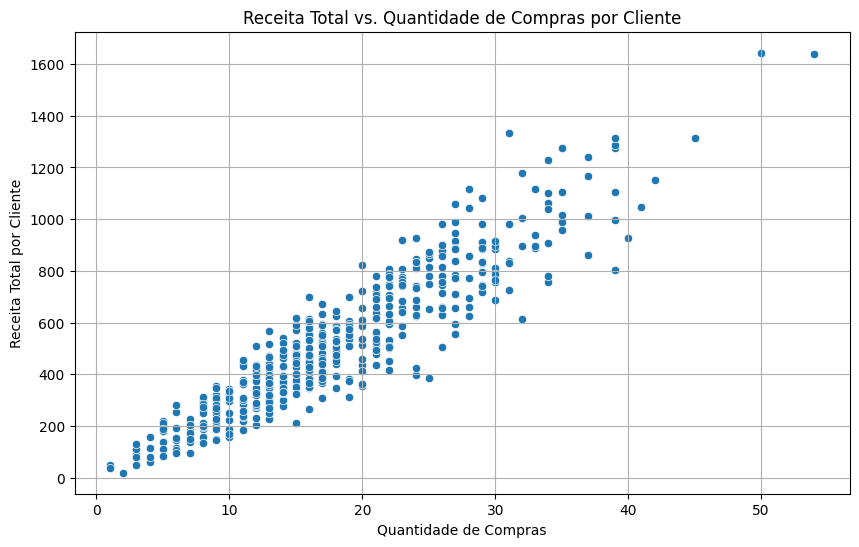

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

df_receita_frequencia = receita_por_cliente.join(
    frequencia_cliente,
    'customer_id',
    'inner'
)

pandas_df = df_receita_frequencia.toPandas()

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=pandas_df,
    x='qtd_compras',
    y='receita_total_por_cliente'
)

plt.title('Receita Total vs. Quantidade de Compras por Cliente')
plt.xlabel('Quantidade de Compras')
plt.ylabel('Receita Total por Cliente')
plt.grid(True)
plt.show()

### Insight 1: A maioria dos clientes realiza poucas compras ao longo do período analisado, indicando um comportamento mais pontual do que recorrente.

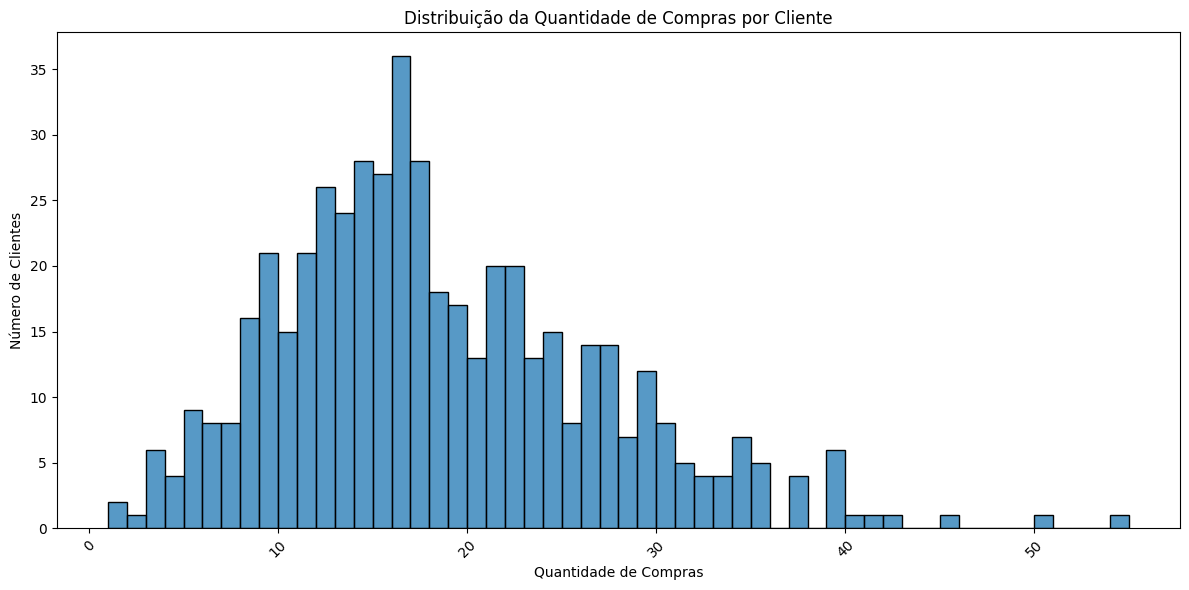

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert frequencia_cliente to Pandas for plotting
frequencia_cliente_pandas = frequencia_cliente.toPandas()

plt.figure(figsize=(12, 6))
sns.histplot(frequencia_cliente_pandas['qtd_compras'], bins=range(1, frequencia_cliente_pandas['qtd_compras'].max() + 2), kde=False)
plt.title('Distribuição da Quantidade de Compras por Cliente')
plt.xlabel('Quantidade de Compras')
plt.ylabel('Número de Clientes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Insight 2: Produtos mais vendidos em quantidade não são necessariamente os produtos que mais geram receita, evidenciando diferenças de valor agregado entre itens do portfólio.

In [33]:
from pyspark.sql.functions import col, sum as spark_sum

# Aggregate product data for plotting
df_product_summary = df_com_receita_total.groupBy('product_name').agg(
    spark_sum('calculated_quantity').alias('total_quantity_sold'),
    spark_sum('receita_total').alias('total_revenue')
).toPandas() # Convert to Pandas for plotting

/tmp/ipython-input-4229682201.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='total_quantity_sold', y='product_name', data=top_quantity_products, palette='viridis')
/tmp/ipython-input-4229682201.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='total_revenue', y='product_name', data=top_revenue_products, palette='magma')


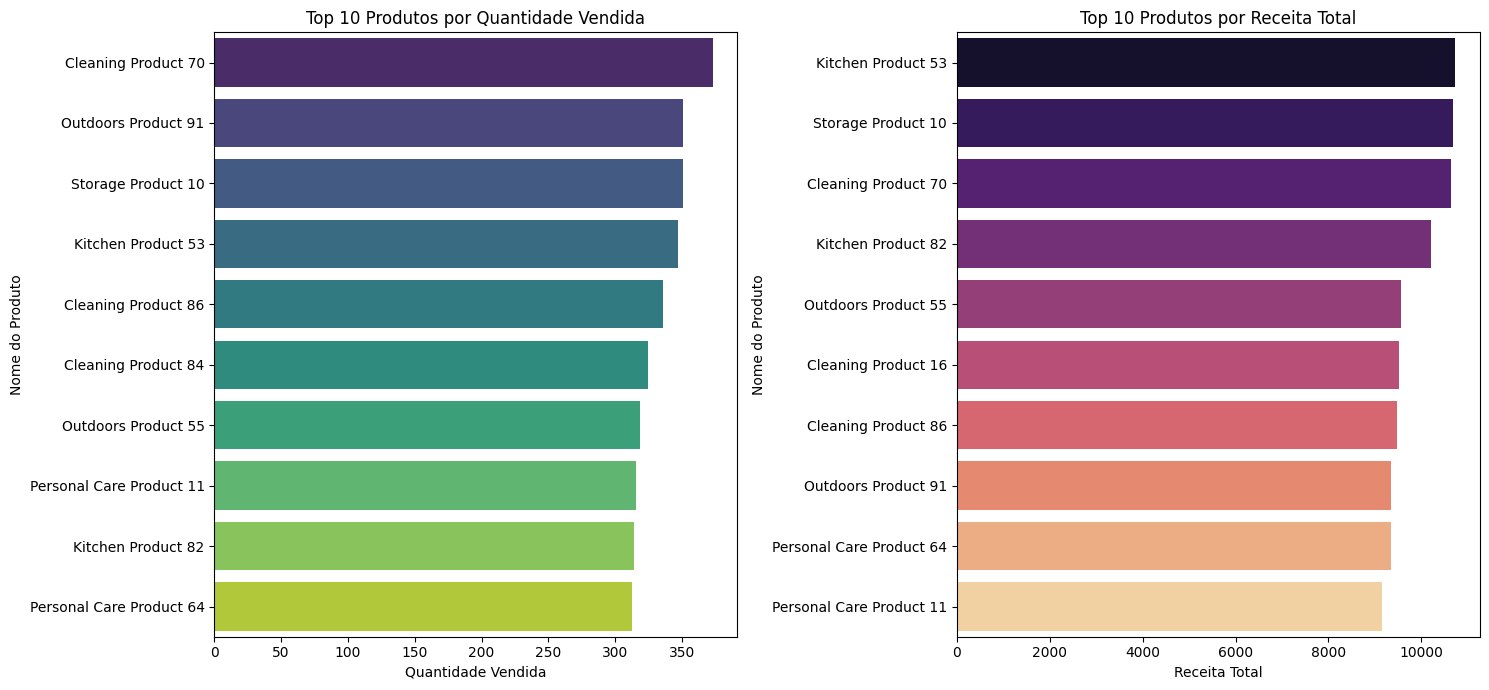

In [34]:
top_quantity_products = df_product_summary.sort_values('total_quantity_sold', ascending=False).head(10)
top_revenue_products = df_product_summary.sort_values('total_revenue', ascending=False).head(10)

plt.figure(figsize=(15, 7))

# Plot for Top Quantity Sold
plt.subplot(1, 2, 1)
sns.barplot(x='total_quantity_sold', y='product_name', data=top_quantity_products, palette='viridis')
plt.title('Top 10 Produtos por Quantidade Vendida')
plt.xlabel('Quantidade Vendida')
plt.ylabel('Nome do Produto')

# Plot for Top Revenue
plt.subplot(1, 2, 2)
sns.barplot(x='total_revenue', y='product_name', data=top_revenue_products, palette='magma')
plt.title('Top 10 Produtos por Receita Total')
plt.xlabel('Receita Total')
plt.ylabel('Nome do Produto')

plt.tight_layout()
plt.show()

### Insight 3: Foram identificados produtos com baixo volume de vendas e baixa geração de receita, sugerindo possíveis candidatos à revisão de portfólio ou estratégias de descontinuação.

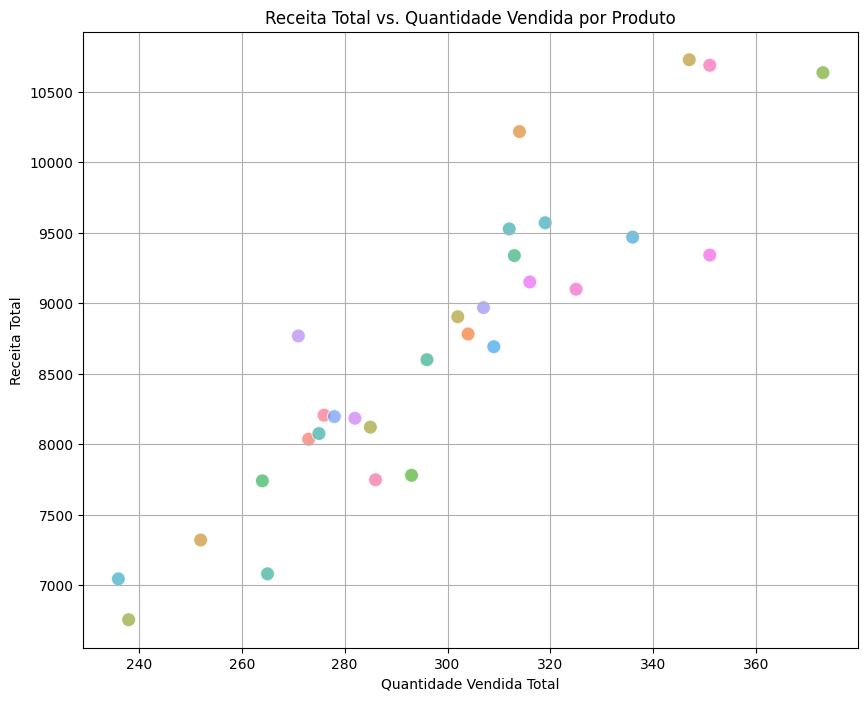

In [35]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='total_quantity_sold', y='total_revenue', data=df_product_summary, hue='product_name', legend=False, s=100, alpha=0.7)
plt.title('Receita Total vs. Quantidade Vendida por Produto')
plt.xlabel('Quantidade Vendida Total')
plt.ylabel('Receita Total')
plt.grid(True)
plt.show()

#### Comentário sobre o Insight 1: Distribuição da Quantidade de Compras por Cliente

Este histograma ilustra a frequência com que os clientes realizam compras. Podemos observar que uma grande parcela dos clientes está concentrada nas faixas de menor quantidade de compras, confirmando que a maioria dos clientes faz poucas transações. Isso sugere que o comportamento de compra é mais pontual do que recorrente para a base de clientes geral, e pode indicar oportunidades para estratégias de retenção ou incentivo à recompra.

#### Comentário sobre o Insight 2: Top 10 Produtos por Quantidade Vendida vs. Receita Total

Os dois gráficos de barras acima demonstram que os produtos mais vendidos em volume (quantidade) nem sempre são os que geram a maior receita. Isso aponta para a existência de produtos com alto giro, mas baixo valor unitário, e produtos com menor volume de vendas, mas alto valor agregado. É crucial analisar ambos os aspectos para entender o verdadeiro impacto de cada item no portfólio e otimizar estratégias de precificação e marketing.

#### Comentário sobre o Insight 3: Receita Total vs. Quantidade Vendida por Produto

Este gráfico de dispersão permite identificar visualmente produtos que apresentam tanto baixo volume de vendas quanto baixa geração de receita. Os pontos localizados no canto inferior esquerdo do gráfico representam esses itens, que podem ser considerados 'produtos de baixo desempenho'. A análise desses produtos é fundamental para decisões estratégicas, como a revisão de estoque, campanhas promocionais direcionadas ou até mesmo a descontinuação para otimizar recursos e portfólio.

In [22]:
from pyspark.sql.functions import col, expr

# Criação de métricas

df_com_receita_total = df_final.withColumn(
    'calculated_quantity', expr("try_cast(quantity AS DOUBLE)")
).withColumn(
    'receita_total',
    col('calculated_quantity') * col('unit_price')
).fillna(0.0, subset=['receita_total']) # Fill NULLs in receita_total resulting from malformed quantities

df_com_receita_total.show()

+----------+--------+-----------+--------+----------+----------+---------------+--------------+-------+----------------+--------------------+-----------+------+------------+--------------------+-------------+-----------+----------+-------------+-------------------+------------------+
|product_id|order_id|customer_id|quantity|unit_price|order_date|delivery_status|payment_method| region|discount_applied|               email|signup_date|gender|loyalty_tier|        product_name|     category|launch_date|base_price|supplier_code|calculated_quantity|     receita_total|
+----------+--------+-----------+--------+----------+----------+---------------+--------------+-------+----------------+--------------------+-----------+------+------------+--------------------+-------------+-----------+----------+-------------+-------------------+------------------+
|     P0022| O966977|     C00397|       3|     39.25|2025-07-06|      Delivered|        PayPal|Central|             0.0|jacquelinemartin@...| 202

In [23]:
df_final = df_com_receita_total

# Corrigindo o erro: usando a função de agregação spark_sum com col('receita_total')
df_final.groupBy(
    'order_date'
).agg(spark_sum(col('receita_total')).alias('receita_total_por_data')).show()

+----------+----------------------+
|order_date|receita_total_por_data|
+----------+----------------------+
|2025-07-06|    260746.33999999982|
+----------+----------------------+



In [ ]:
from pyspark.sql.functions import month

df_com_receita_total.withColumn(
    'month', month(col('order_date'))
).groupBy('month').count().orderBy('month', ascending=True).show()

In [21]:
from pyspark.sql.functions import month

receita_por_mes = df_com_receita_total.withColumn(
    'month', month(col('order_date'))
).groupBy('month').agg(
    spark_sum('receita_total').alias('receita_total_por_mes')
).orderBy('month', ascending=True)

receita_por_mes.show()

#todas as vendas apenas em julho

+-----+---------------------+
|month|receita_total_por_mes|
+-----+---------------------+
|    7|   260746.33999999982|
+-----+---------------------+



In [ ]:
# Insight 1 A receita total por cliente não está diretamente relacionada à frequência de compra. Clientes com menor número de compras apresentam tickets médios mais altos, sendo responsáveis por uma parcela relevante da receita.



In [26]:
frequencia_cliente = (
    sales_data
    .groupBy('customer_id')
    .agg(
        spark_sum('quantity').alias('qtd_compras')
    )
).show()

receita_frequencia = (
    sales_data
        .groupBy("customer_id")
        .agg(
            spark_sum(col("quantity") * col("unit_price")).alias("receita_total"),
            countDistinct("order_id").alias("qtd_compras")
        ).orderBy('receita_total', ascending=False )
).show()

#O valor médio por compra é mais determinante do que a frequência.

# Não necessariamente. Observa-se que clientes com menor ou média frequência de compras podem gerar receitas totais elevadas, indicando tickets médios mais altos por pedido.

+-----------+-----------+
|customer_id|qtd_compras|
+-----------+-----------+
|     C00126|         24|
|     C00394|         12|
|     C00169|         17|
|     C00049|         13|
|     C00006|         20|
|     C00310|         27|
|     C00057|         12|
|     C00195|         17|
|     C00261|         10|
|     C00172|         16|
|     C00244|         19|
|     C00061|         15|
|     C00075|          7|
|     C00306|         12|
|     C00196|         21|
|     C00239|          8|
|     C00311|         21|
|     C00156|         12|
|     C00174|         42|
|     C00439|         15|
+-----------+-----------+
only showing top 20 rows
+-----------+------------------+-----------+
|customer_id|     receita_total|qtd_compras|
+-----------+------------------+-----------+
|     C00108|           1644.06|         13|
|     C00385|1638.8200000000002|         15|
|     C00104|           1332.88|          9|
|     C00500|           1315.79|         12|
|     C00062|1314.0299999999997|    

In [46]:
df_clientes_final = df_receita_frequencia.toPandas()
df_produtos_final = df_product_summary # df_product_summary já é um Pandas DataFrame
df_vendas_mensal = receita_por_mes.toPandas()

df_clientes_final.to_csv("clientes.csv", index=False)
df_produtos_final.to_csv("produtos.csv", index=False)
df_vendas_mensal.to_csv("vendas_mensal.csv", index=False)

files.download("clientes.csv")
files.download("produtos.csv")
files.download("vendas_mensal.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Conclusões

Principais insights:

A receita total por cliente não está diretamente relacionada à frequência de compra. Observou-se que clientes com menor número de compras apresentam tickets médios mais elevados, sendo responsáveis por uma parcela relevante da receita total.

A maior parte dos clientes realiza compras de forma pontual, com baixa recorrência, indicando que o comportamento predominante não é de compras frequentes, mas sim de pedidos de maior valor.

Produtos com maior volume de vendas não são necessariamente os que geram maior receita, evidenciando diferenças de valor agregado entre os itens do portfólio. Além disso, foram identificados produtos com baixo volume de vendas e baixa geração de receita, sugerindo oportunidades de revisão do portfólio.

Limitações da análise:

A análise temporal das vendas é limitada, pois todas as transações do conjunto de dados ocorreram no mês de julho, impossibilitando a avaliação de tendências, crescimento ou sazonalidade ao longo do tempo.

Sugestão de próxima análise:

Como próxima etapa, recomenda-se a análise da retenção de clientes ao longo de um período mais amplo, permitindo avaliar padrões de recompra e identificar estratégias para aumentar a recorrência dos clientes de maior ticket médio.


In [42]:
df_final_pd = df_final.toPandas()
df_final_pd.to_csv("df_final.csv", index=False)

In [44]:
from google.colab import files
files.download("df_final.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>